<a href="https://colab.research.google.com/github/nabinyd/60-Days-of-learning/blob/main/DLPT_08_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 42

# 8. Pytorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer.

## 0. Get Setup

Let's import code we've written + required libraries.



In [26]:
import torch
import torchvision

torch.__version__


'2.3.0+cu121'

In [27]:
torchvision.__version__

'0.18.0+cu121'

In [28]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [29]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely the pizza, steak and sushi images

In [30]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [31]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [32]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [33]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMAGE_SIZE = 224    # comes from Table od the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                        transforms.ToTensor()])

print(f"Manually created tranforms:  {manual_transforms}")


Manually created tranforms:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [34]:
# Create a batch size of 32

BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

# Day 43

### 2.3 Visualize a single a image

In [35]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

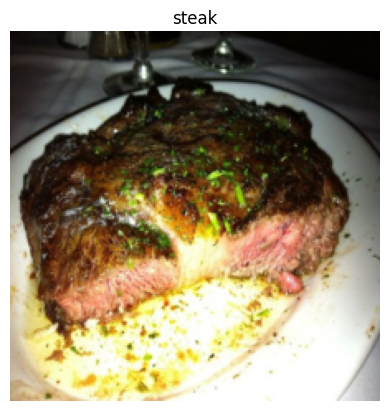

In [36]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))   # (color_channels, height, width) --> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)


## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to amke it more understandable, we can break it down into smaller pieces:

*  **Inputs**: WHat goes into the model? (in our case, image tensors)
*  **Outputs**: What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)

* **Layers**: Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks**: A collection of layers
* **Model (or Architecture)**: A collection of blocks

### 3.1 ViT overview: pieces of the puzzle


* Figure 1: Visual overview of the architecture
* Four equatoins: math equations which define the functions of each layer/block
* Table 1/3: differernt hyperparameters for the architecture/training
* Text descriptions

### Figure 1

* Embedding = learnable representation (start with random numbers and improve over time)


### Four equations


### Table 1



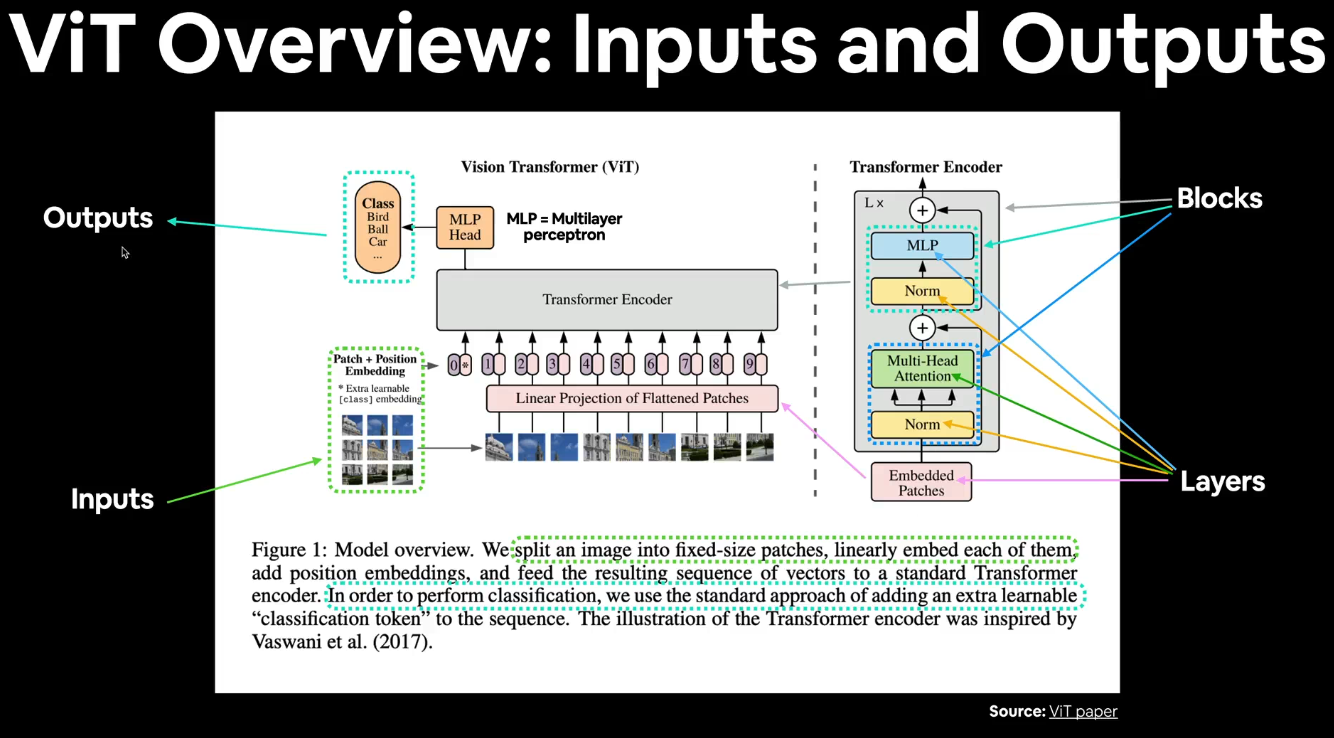

# Day 45


### 3.1 describes various equations:


**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 . C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP: Multilayer perceptron = a neural network with x number of layers

* MLP: One hidden layer at training time

* MLP: single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4

y = Linear_layer(LN_layer(x_output_MLP_block))
```

**Equation 1:**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]

```

**Equation 2 & 3**:


The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

### **Four equations**

The MLP contains two layers with a GELU non-linearity.
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 . C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

**Inductive bias.** We note that Vision Transformer has much less image-specific inductive bias than CNNs. In CNNs, locality, two-dimensional neighborhood structure, and translation equivariance are baked into each layer throughout the whole model. In ViT, only MLP layers are local and translationally equivariant, while the self-attention layers are global. The two-dimensional neighborhood structure is used very sparingly: in the beginning of the model by cutting the image into patches and at fine-tuning time for adjusting the position embeddings for images of different resolution (as described below). Other than that, the position embeddings at initialization time carry no information about the 2 D positions of the patches and all spatial relations between the patches have to be learned from scratch.

**Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size 1 x 1 , which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

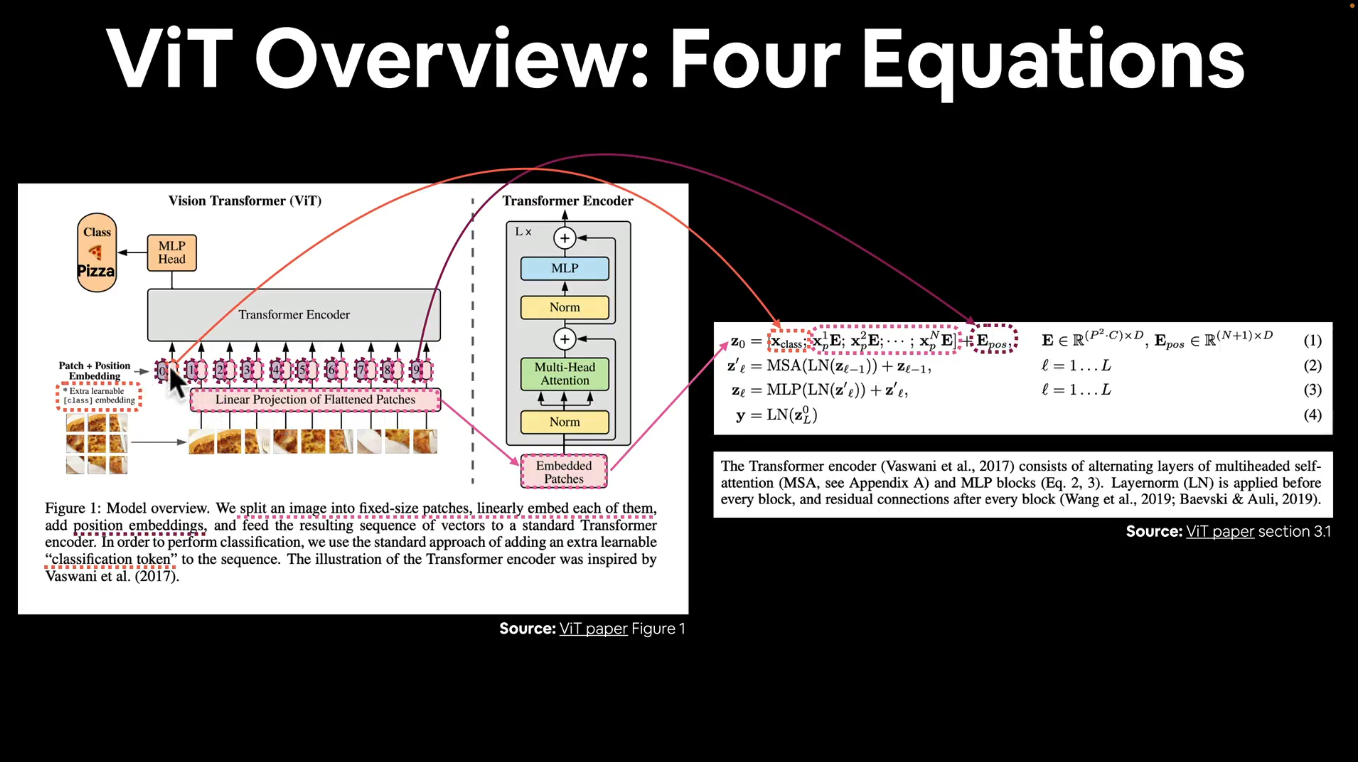

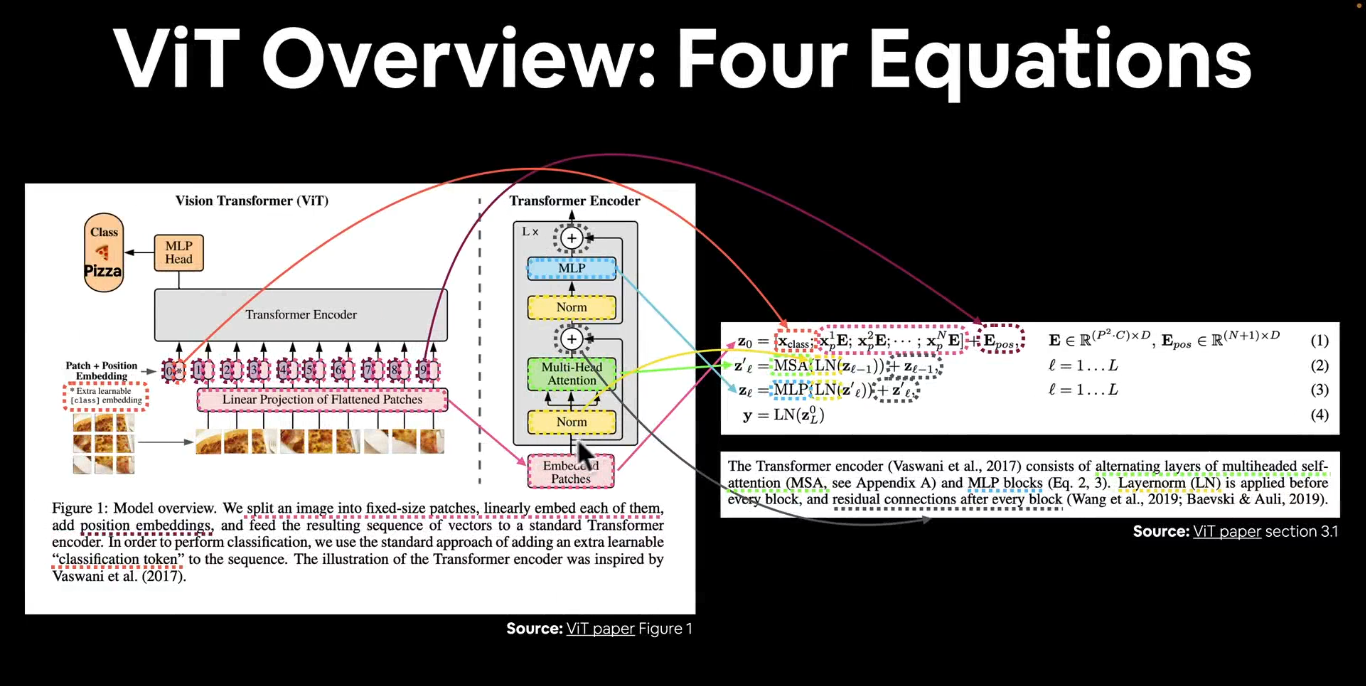

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="tbale1"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.

* Layers - the number of transformer encoder layers

* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP

* Head - the number of multi-head self attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

### 4.1 Calculating patch embedding input and output shapes by hand


Layers = input -> function -> output

What's  the input shape?

What's the output shape?

* Input shape: $H\times{W}\times{C}$  (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C - color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latetnt vector size = embedding dimension  

In [37]:
 # Create example values
 height = 224
 width = 224
 color_channels = 3
 patch_size = 16


 # Calculate the number of patches
 number_of_patches = int((height * width)/ patch_size ** 2)
 number_of_patches

196

In [38]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches



(-0.5, 223.5, 223.5, -0.5)

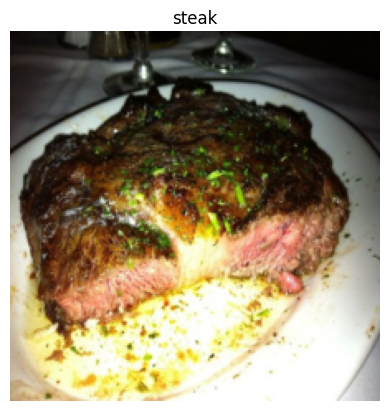

In [39]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

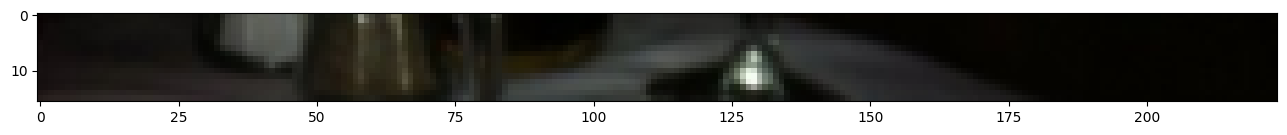

In [40]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row the pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:, :])

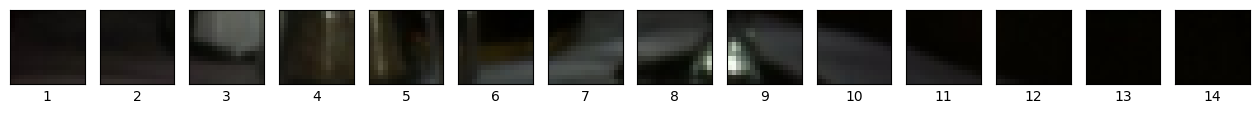

In [41]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a s eries of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,    # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i + 1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


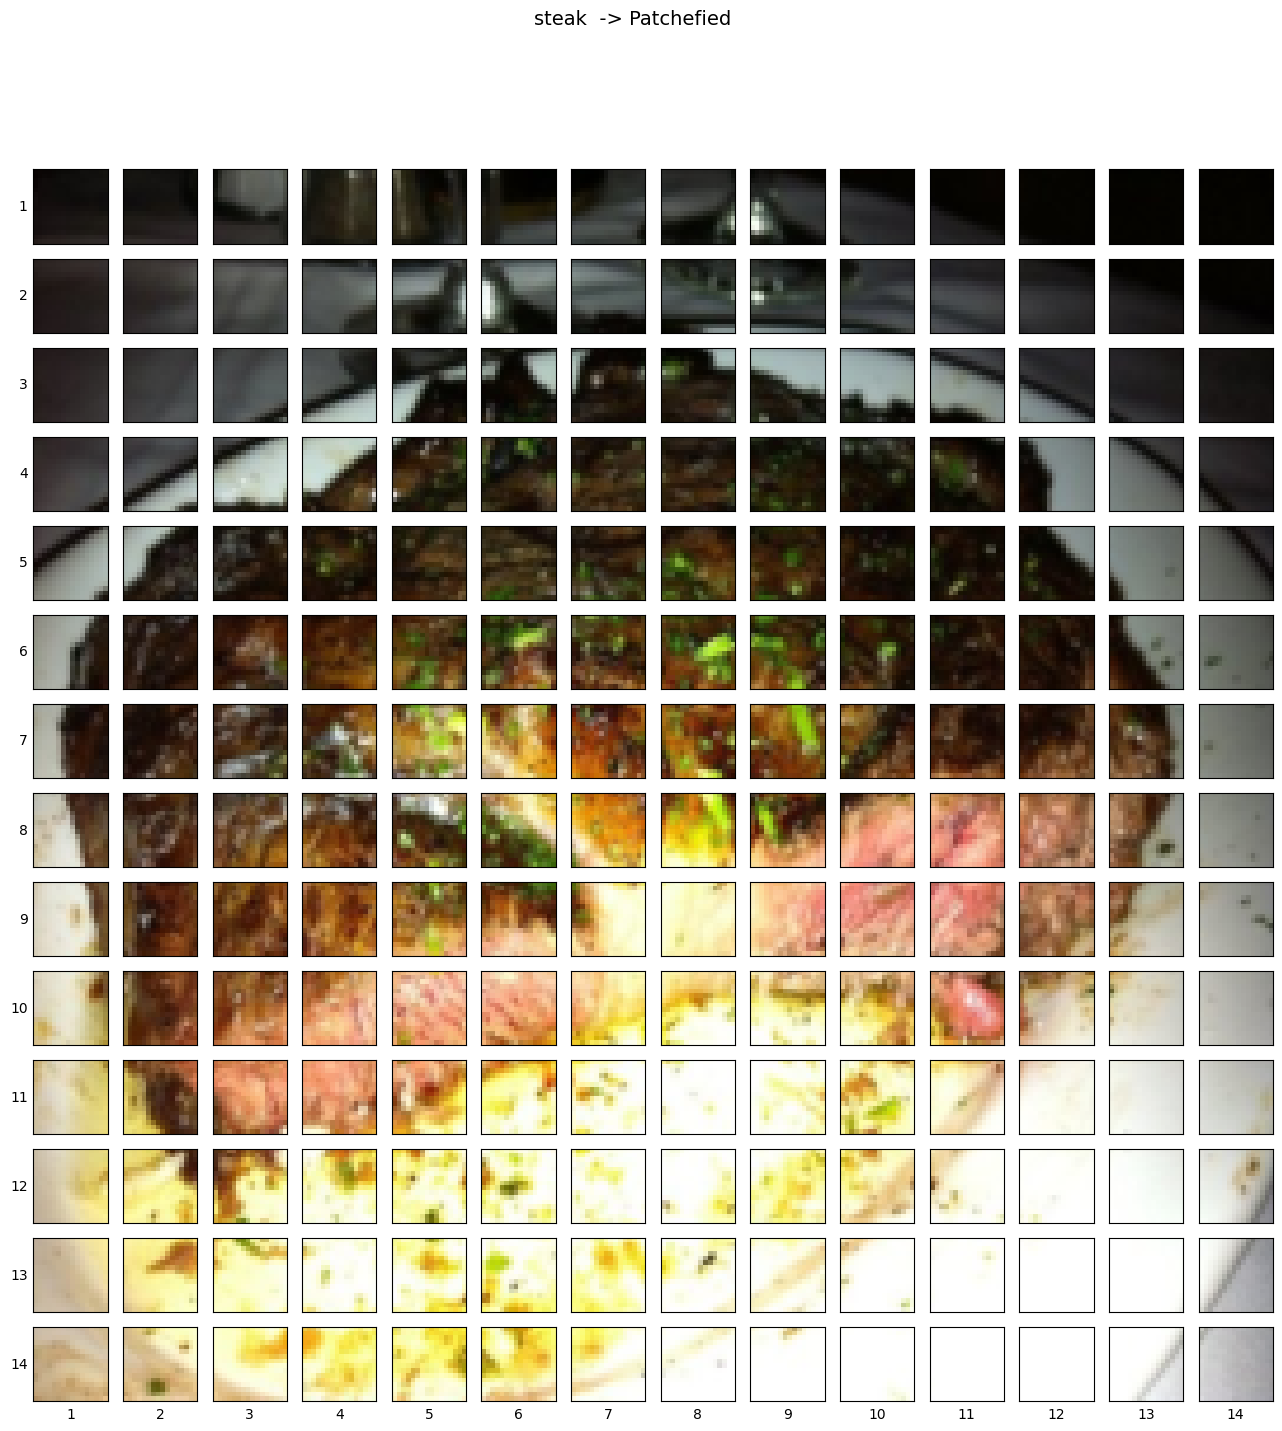

In [42]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")


# Create  a series of subplots
fig, axs =  plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,    # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterate through number of patches in the top row
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size,
                                    :])  # Get all color channels
    # Setup label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

  # Setup a title for the plot
fig.suptitle(f"{class_names[label]}  -> Patchefied", fontsize=14)
plt.show()

# Day 46

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [43]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)

from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,     # For color images
                   out_channels=768,     # D size from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0
                   )

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

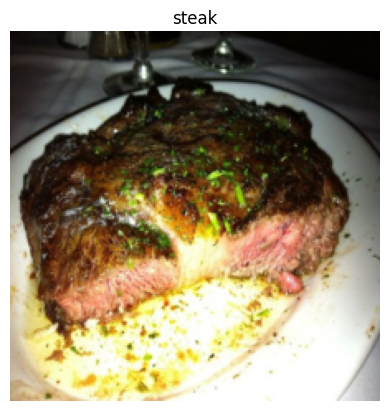

In [44]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [45]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))    # Add batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a singel image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14])    # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Shoing random convolutional feature maps from indexes: [8, 47, 54, 749, 255]


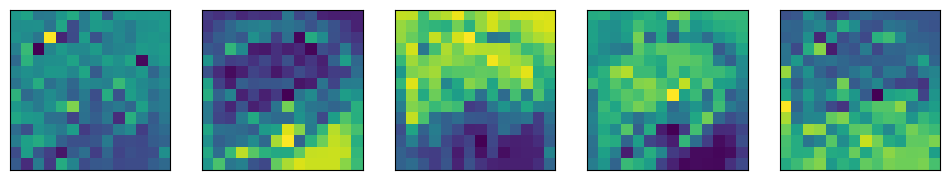

In [46]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Shoing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))


# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:, :]    # index on the ouput tensor
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [47]:
#  Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, : ]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 2.7038e-02,  2.3071e-02,  1.4021e-01,  4.5405e-02,  2.2742e-02,
            4.5882e-05,  7.9097e-02,  7.9323e-02,  1.2399e-02,  4.8585e-02,
           -2.2601e-02, -2.3741e-02, -1.5511e-02, -1.4948e-02],
          [ 5.9181e-02,  1.0862e-01,  1.5707e-01,  1.2324e-01,  1.3172e-01,
            2.1260e-01,  1.5551e-01,  1.1853e-01,  5.1437e-02,  6.5740e-02,
            8.2518e-02,  4.3099e-02,  4.0675e-03, -1.7322e-02],
          [ 7.0086e-02,  1.2496e-01,  1.5221e-01,  1.8060e-01, -3.8583e-02,
            3.6562e-02, -2.8821e-02,  1.4790e-01,  1.5439e-01,  2.2051e-01,
            2.0768e-01,  3.3150e-02,  4.8042e-02,  7.4843e-03],
          [ 1.0353e-01,  1.8388e-01,  3.2309e-01,  2.6205e-01, -3.2657e-02,
            6.0698e-02,  2.2762e-02,  3.5659e-02,  4.9312e-03,  5.2595e-02,
            1.5958e-02,  2.7562e-01,  9.6292e-02,  1.9488e-02],
          [ 1.7205e-01, -3.3290e-02,  1.1538e-03,  3.2461e-02,  4.6775e-02,
            3.1404e-02,  2.5574e-02,  4.9992e-02, -9.5645e-0

### 4.4 Flattening the patch embeding with `torch.nn.Flatten()`


Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddingsto satisfy the criteria of the ViT Transformer criteria Encoder.

In [49]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [51]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


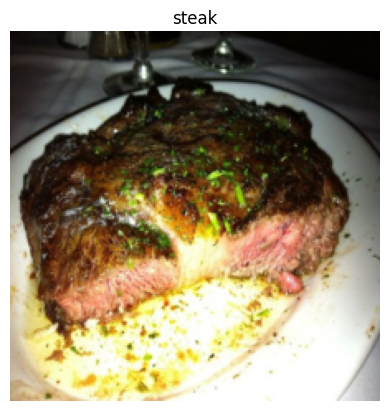

In [52]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [58]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape }  -> (batch_size, number_of_patches, embedding dimension)")

torch.Size([1, 196, 768])  -> (batch_size, number_of_patches, embedding dimension)


(-0.5, 195.5, 0.5, -0.5)

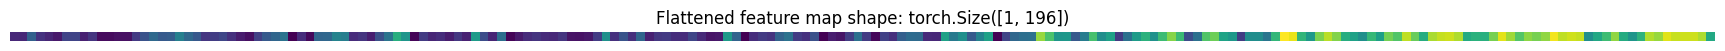

In [60]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
# single_flattened_feature_map

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into oa PyTorch module

We want this module to do a few things:
1. Create a class called `Patchembedding`
2. Initialize with appropriate hyperparametrs, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()`that defines the forward computation (e.g pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [61]:
 # 1. Create a class PatchEmbedding
 class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    # 3. Create a layer to turn an image into embedded
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image sizemust be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

In [62]:
set_seeds()
# create an instance of embedding
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))    # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])
